In [6]:
#AlexNet
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 11, stride = 4)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(32, 256, kernel_size = 5, padding = 2)
        self.conv3= nn.Conv2d(256, 384, kernel_size = 3, padding = 1)
        self.conv4= nn.Conv2d(384, 384, kernel_size = 3, padding = 1)
        self.conv5= nn.Conv2d(384, 256, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(256*5*5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x
        
batch_size = 256
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

fashion_mnist_trainval = FashionMNIST("FashionMNIST", train=True, download=True, transform=transform)
fashion_mnist_test = FashionMNIST("FashionMNIST", train=False, download=True, transform=transform)

n_samples = len(fashion_mnist_trainval) 
train_size = int(len(fashion_mnist_trainval) * 0.8) 
val_size = n_samples - train_size 

train_dataset, val_dataset = torch.utils.data.random_split(fashion_mnist_trainval, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

cuda:0


In [7]:
net = AlexNet()
net.to(device)

best_score = 100.0
count = 0
stop = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002)
epoch_num = 200
running_loss = np.zeros(epoch_num)
val_running_loss = np.zeros(epoch_num)

for epoch in range(epoch_num):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() 
        outputs = net(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
        running_loss[epoch] += loss.item()
        
    for i, data in enumerate(val_loader, 0):    
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() 
        outputs = net(inputs) 
        val_loss = criterion(outputs, labels) 
        val_loss.backward() 
        optimizer.step() 
        val_running_loss[epoch] += val_loss.item()
        
    running_loss[epoch] /= len(train_loader)
    val_running_loss[epoch] /= len(val_loader)

    if val_running_loss[epoch] > best_score:
        count += 1
        print("count:", count)

    else:
        count = 0
        best_score = val_running_loss[epoch]

    if count >= stop:
        print("early stopping")
        break
  

    print("epoch : %d, train_loss : %.4lf, val_loss : %.4lf" % (epoch, running_loss[epoch],val_running_loss[epoch]))
    

epoch : 0, train_loss : 2.3024, val_loss : 2.3021
epoch : 1, train_loss : 2.3021, val_loss : 2.3017
epoch : 2, train_loss : 2.3017, val_loss : 2.3013
epoch : 3, train_loss : 2.3013, val_loss : 2.3010
epoch : 4, train_loss : 2.3009, val_loss : 2.3004
epoch : 5, train_loss : 2.3003, val_loss : 2.2998
epoch : 6, train_loss : 2.2997, val_loss : 2.2991
epoch : 7, train_loss : 2.2988, val_loss : 2.2981
epoch : 8, train_loss : 2.2977, val_loss : 2.2968
epoch : 9, train_loss : 2.2963, val_loss : 2.2950
epoch : 10, train_loss : 2.2941, val_loss : 2.2924
epoch : 11, train_loss : 2.2907, val_loss : 2.2878
epoch : 12, train_loss : 2.2846, val_loss : 2.2786
epoch : 13, train_loss : 2.2693, val_loss : 2.2498
epoch : 14, train_loss : 2.2061, val_loss : 2.1026
epoch : 15, train_loss : 1.6853, val_loss : 1.2407
epoch : 16, train_loss : 1.0832, val_loss : 0.9639
epoch : 17, train_loss : 0.9006, val_loss : 0.8475
epoch : 18, train_loss : 0.8236, val_loss : 0.7873
epoch : 19, train_loss : 0.7753, val_loss

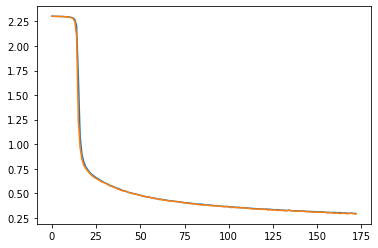

In [8]:
plt.plot(running_loss[0:epoch+1])
plt.plot(val_running_loss[0:epoch+1])

In [9]:
train_acc = 0.0
correct = 0.0
count = 0.0

with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, pred_label = torch.max(outputs.data, 1)
        for j in range(len(pred_label)):
            if pred_label[j].int() == labels[j]:
            correct += 1
        count += 1

train_acc = correct/count
print("train_acc:",train_acc)



test_acc = 0.0
correct = 0.0
count = 0.0

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, pred_label = torch.max(outputs.data, 1)
    
    for j in range(len(pred_label)):
        if pred_label[j].int() == labels[j]:
            correct += 1  
        count += 1

test_acc = correct/count
print("test_acc:",test_acc)

train_acc: 0.8891875
test_acc: 0.875
